# LAB2 Artificial Intelligence for Autonomous Systems

First step is to convert input image to grayscale

In [71]:
# Install dependencies
!pip install Pillow
!pip install matplotlib
!pip install opencv-python
!pip install torchvision
!pip install tensorboard
!Pip install sklearn

/bin/bash: line 1: Pip: command not found


In [3]:
from PIL import Image
import os

def convert_to_grayscale(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        input_path = os.path.join(input_dir, filename)

        if os.path.isfile(input_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            with Image.open(input_path) as img:
                grayscale_img =  img.convert('L')

                output_path = os.path.join(output_dir, filename)

                grayscale_img.save(output_path)
                print(f"Converted {filename} to grayscale and saved as {output_path}")

input_directory = "./dataset/base_input"
output_directory = "./dataset/grayscale_input"

convert_to_grayscale(input_directory, output_directory)


Converted photo_23_2024-03-19_17-10-36-copy-0.jpg to grayscale and saved as ./dataset/grayscale_input/photo_23_2024-03-19_17-10-36-copy-0.jpg
Converted photo_1_2024-03-19_17-10-36.jpg to grayscale and saved as ./dataset/grayscale_input/photo_1_2024-03-19_17-10-36.jpg
Converted photo_17_2024-03-19_17-10-36.jpg to grayscale and saved as ./dataset/grayscale_input/photo_17_2024-03-19_17-10-36.jpg
Converted photo_19_2024-03-19_17-10-36.jpg to grayscale and saved as ./dataset/grayscale_input/photo_19_2024-03-19_17-10-36.jpg
Converted photo_9_2024-03-19_17-10-36.jpg to grayscale and saved as ./dataset/grayscale_input/photo_9_2024-03-19_17-10-36.jpg
Converted photo_2_2024-03-19_17-10-36.jpg to grayscale and saved as ./dataset/grayscale_input/photo_2_2024-03-19_17-10-36.jpg
Converted photo_7_2024-03-19_17-10-36.jpg to grayscale and saved as ./dataset/grayscale_input/photo_7_2024-03-19_17-10-36.jpg
Converted photo_13_2024-03-19_17-10-36.jpg to grayscale and saved as ./dataset/grayscale_input/pho

Now I'll apply 4 random rotation to each images. This step can be ignored if it doesn't contribute to improve the accuracy of our model

In [4]:
import random

def rotate_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        input_path = os.path.join(input_dir, filename)

        if os.path.isfile(input_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            with Image.open(input_path) as img:
                for i in range(4):
                    angle = random.randint(0, 360)
                    
                    rotated_img = img.rotate(angle)
                    
                    output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_{angle}deg.jpg")
                    
                    rotated_img.save(output_path)
                    print(f"Applied {angle} degree rotation to {filename} and saved as {output_path}")

input_directory = "./dataset/grayscale_input"
output_directory = "./dataset/extended_set"

rotate_images(input_directory, output_directory)

Applied 240 degree rotation to photo_23_2024-03-19_17-10-36-copy-0.jpg and saved as ./dataset/extended_set/photo_23_2024-03-19_17-10-36-copy-0_240deg.jpg
Applied 59 degree rotation to photo_23_2024-03-19_17-10-36-copy-0.jpg and saved as ./dataset/extended_set/photo_23_2024-03-19_17-10-36-copy-0_59deg.jpg
Applied 260 degree rotation to photo_23_2024-03-19_17-10-36-copy-0.jpg and saved as ./dataset/extended_set/photo_23_2024-03-19_17-10-36-copy-0_260deg.jpg
Applied 165 degree rotation to photo_23_2024-03-19_17-10-36-copy-0.jpg and saved as ./dataset/extended_set/photo_23_2024-03-19_17-10-36-copy-0_165deg.jpg
Applied 225 degree rotation to photo_1_2024-03-19_17-10-36.jpg and saved as ./dataset/extended_set/photo_1_2024-03-19_17-10-36_225deg.jpg
Applied 0 degree rotation to photo_1_2024-03-19_17-10-36.jpg and saved as ./dataset/extended_set/photo_1_2024-03-19_17-10-36_0deg.jpg
Applied 291 degree rotation to photo_1_2024-03-19_17-10-36.jpg and saved as ./dataset/extended_set/photo_1_2024-03

## Determine the line on each image 

This step will allow us to train the model we need some image with corresponding white line or vector

[Lane detection](https://medium.com/@mrhwick/simple-lane-detection-with-opencv-bfeb6ae54ec0)

1. Canny edge detection on the image to detect every line
2. Crop each image to clean the part where there's no chance to have a line.
3. Hough line transform in order to bring out lines created by nearest pixel going in a same direction
4. Find the longuest line 
5. Apply mask with the detected line on the original picture

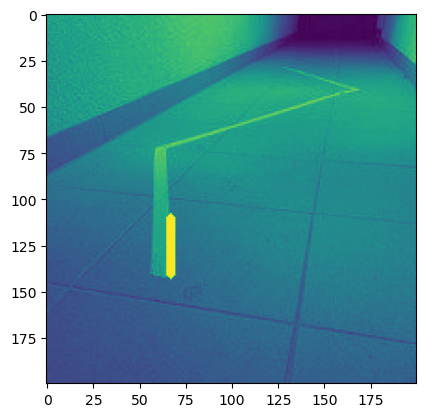

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

height = width = 200
horizontal_ratio = 0.2

lower_threshold = 250
upper_threshold = 350

region_of_interest_vertices = [
    (0, height),
    (width / 2, height / 2 - (horizontal_ratio * height)),
    (width, height),
]

# Croppe region of interest
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    match_mask_color = 255

    cv2.fillPoly(mask, vertices, match_mask_color)

    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

# Draw vector director on image
def draw_lines(img, lines, color=[255,0,0], thickness=3):
    if lines is None:
        return
    
    img = np.copy(img)
    
    line_img = np.zeros(
        (img.shape[0],
        img.shape[1]),
        dtype=np.uint8,
    )

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1 ,y1), (x2, y2), color, thickness)
    
    cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0, img)

    return img

# Get the longest vector
def longest_vector(vector_list):
    max_length = 0
    longest_vector = None
    
    for vector in vector_list:
        x1, y1, x2, y2 = vector[0]
        length = ((x2 - x1)**2 + (y2 - y1)**2) ** 0.5
        if length > max_length:
            max_length = length
            longest_vector = vector
    
    return [longest_vector]

# Annotate imges
def img_lane_annotate(img):
    # Edge detection
    cannyed_image = cv2.Canny(img, lower_threshold, upper_threshold)

    # Cropped useless artifact
    cropped_image = region_of_interest(
        cannyed_image,
        np.array([region_of_interest_vertices], np.int32),
    )

    # Determine guidelines
    lines = []
    lines = cv2.HoughLinesP(
        cropped_image,
        rho=6,
        theta=np.pi / 60,
        threshold=10,
        lines=np.array([]),
        minLineLength=25,
        maxLineGap=10
    )
    
    if lines is None:
        return img
    
    line = longest_vector(lines)

    return draw_lines(img, line), line

image = mpimg.imread('./dataset/grayscale_input/photo_1_2024-03-19_17-10-36.jpg')

annotated_img, line = img_lane_annotate(image)

plt.figure()
plt.imshow(annotated_img)
plt.show()



### Annotate every pictures in grayscale

In [39]:
def annotate_images(input_dir, output_dir):
    lines = []
    paths = []

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Clean output dir
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    # Annotate every image
    for idx, filename in enumerate(os.listdir(input_dir)):
        input_path = os.path.join(input_dir, filename)

        if os.path.isfile(input_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            img = mpimg.imread(input_path)
            annotated_img, line = img_lane_annotate(img)
            lines.append(line[0][0])
            paths.append(input_path)

            output_filename = f"image{idx}.jpg"
            output_path = os.path.join(output_dir, output_filename)

            mpimg.imsave(output_path, annotated_img)

    return lines, paths

## Making the CNN network

Reuse the work of [https://github.com/hugohadfield/pytorch_image_regession](https://github.com/hugohadfield/pytorch_image_regession)

Now the goal is to prepare a dataframe linking image path and his corresponding vector

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)

input_directory = "./dataset/grayscale_input"
output_directory = "./output/line_annotated"

def create_dataframe(input_dir, output_dir):
    
    lines, paths = annotate_images(input_dir, output_dir)
    df_paths = pd.DataFrame(paths, columns=['image_path'])
    df_coor = pd.DataFrame(lines, columns=['x1', 'y1', 'x2', 'y2'])
    df = pd.concat([df_paths, df_coor], axis=1)
    return df

df = create_dataframe(input_directory, output_directory)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

train_df.to_csv(os.path.join(input_directory, "train.csv"), sep=',', index=False)

test_df.to_csv(os.path.join(input_directory, "test.csv"), sep=',', index=False)

print(df)

                                                           image_path   x1  \
0   ./dataset/grayscale_input/photo_23_2024-03-19_17-10-36-copy-0.jpg  104   
1           ./dataset/grayscale_input/photo_1_2024-03-19_17-10-36.jpg   67   
2          ./dataset/grayscale_input/photo_17_2024-03-19_17-10-36.jpg   98   
3          ./dataset/grayscale_input/photo_19_2024-03-19_17-10-36.jpg   44   
4           ./dataset/grayscale_input/photo_9_2024-03-19_17-10-36.jpg   92   
5           ./dataset/grayscale_input/photo_2_2024-03-19_17-10-36.jpg   66   
6           ./dataset/grayscale_input/photo_7_2024-03-19_17-10-36.jpg   84   
7          ./dataset/grayscale_input/photo_13_2024-03-19_17-10-36.jpg   67   
8          ./dataset/grayscale_input/photo_22_2024-03-19_17-10-36.jpg  127   
9          ./dataset/grayscale_input/photo_15_2024-03-19_17-10-36.jpg   75   
10         ./dataset/grayscale_input/photo_18_2024-03-19_17-10-36.jpg   84   
11          ./dataset/grayscale_input/photo_8_2024-03-19_17-10-3

## Loading data

In [83]:
from typing import Dict, Any

from pathlib import Path

import torch
import torch.utils.data 
from torchvision import datasets, transforms


# This is the path to the folder containing the images
DEFAULT_IMAGE_FOLDER_PATH = Path('dataset/grayscale_input')

# This script is set up to crop first, then resize
DEFAULT_CENTRE_CROP_SIZE = 200
DEFAULT_RESIZED_IMAGE_SIZE = 200


def get_transforms(grayscale: bool = False, crop_size: int = DEFAULT_CENTRE_CROP_SIZE, resize_size: int = DEFAULT_RESIZED_IMAGE_SIZE):
    """
    This function returns the transforms that are applied to the images when they are loaded.
    """
    # Set up the transforms on load of the data
    if grayscale:
        train_transforms = transforms.Compose(
            [
                transforms.CenterCrop(crop_size),
                transforms.Resize(resize_size),
                transforms.Grayscale(),
                transforms.ToTensor()
            ]
        )
        # In this case, as we aren't doing any kind of random augmentation we 
        # can use the same transforms for the test data as the train data
        test_transforms = train_transforms
    else:
        train_transforms = transforms.Compose(
            [
                transforms.CenterCrop(crop_size),
                transforms.Resize(resize_size),
                transforms.ToTensor()
            ]
        )
        # In this case, as we aren't doing any kind of random augmentation we 
        # can use the same transforms for the test data as the train data
        test_transforms = train_transforms
    return train_transforms, test_transforms


def load_image_targets_from_csv(csv_path: Path, header: bool = True) -> Dict[str, Any]:
    """
    This function loads the image targets from a csv file. It assumes that the csv file
    has a header row and that the first column contains the image path and all the subsequent
    columns contain the target values which are bundled together into a numpy array.
    """
    image_targets = {}
    with csv_path.open('r') as f:
        lines = f.readlines()
        start_line = 0
        # If there is a header, skip the first line
        if header:
            header_line = lines[0].strip().split(',')
            print(f'Header line of csv {csv_path} : {header_line}')
            start_line = 1
        for line in lines[start_line:]:
            line = line.strip().split(',')
            image_path = line[0]
            image_targets[image_path] = np.array([float(x) for x in line[1:]], dtype=np.float32)
    return image_targets


class RegressionImageFolder(datasets.ImageFolder):
    """
    The regression image folder is a subclass of the ImageFolder class and is designed for 
    image regression tasks rather than image classification tasks. It takes in a dictionary
    that maps image paths to their target values.
    """
    def __init__(
        self, root: str, image_targets: Dict[str, Any], *args: Any, **kwargs: Any
    ) -> None:
        super().__init__(root, *args, **kwargs)
        paths, _ = zip(*self.imgs)
        self.targets = [image_targets[str(path)] for path in paths]
        self.samples = self.imgs = list(zip(paths, self.targets))


class RegressionTaskData:
    """
    This class is a wrapper for the data that is used in the regression task. It contains
    the train and test loaders.
    """
    def __init__(
        self,
        grayscale: bool = False,
        image_folder_path: Path = DEFAULT_IMAGE_FOLDER_PATH,
        crop_size: int = DEFAULT_CENTRE_CROP_SIZE,
        resize_size: int = DEFAULT_RESIZED_IMAGE_SIZE,
    ) -> None:
        self.grayscale = grayscale
        self.image_folder_path = image_folder_path
        self.train_transforms, self.test_transforms = get_transforms(grayscale, crop_size, resize_size)
        self.trainloader = self.make_trainloader()
        self.testloader = self.make_testloader()
        self.crop_size = crop_size
        self.resize_size = resize_size

    @property
    def output_image_size(self):
        return (1 if self.grayscale else 3, self.resize_size, self.resize_size)

    def make_trainloader(
            self, 
        ) -> torch.utils.data.DataLoader:
        """
        Builds the train data loader
        """
        train_data = RegressionImageFolder(
            str(self.image_folder_path), 
            image_targets=load_image_targets_from_csv(self.image_folder_path / 'train.csv'),
            transform=self.train_transforms
        )
        # This constructs the dataloader that actually determins how images will be loaded in batches
        trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
        return trainloader

    def make_testloader(
            self, 
        ) -> torch.utils.data.DataLoader:
        """
        Builds the test data loader
        """
        test_data = RegressionImageFolder(
            str(self.image_folder_path), 
            image_targets=load_image_targets_from_csv(self.image_folder_path / 'test.csv'),
            transform=self.test_transforms
        )
        # This constructs the dataloader that actually determins how images will be loaded in batches
        testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
        return testloader

    def visualise_image(self):
        """
        This function visualises a single image from the train set
        """
        images, targets = next(iter(self.trainloader))
        print(targets[0].shape)
        print(images[0].shape)
        if self.grayscale:
            plt.imshow(images[0][0, :, :], cmap='gray')
        else:
            plt.imshow(images[0].permute(1, 2, 0))
        plt.show()


In [84]:
data = RegressionTaskData()
data.visualise_image()

Header line of csv dataset/grayscale_input/train.csv : ['image_path', 'x1', 'y1', 'x2', 'y2']


FileNotFoundError: Couldn't find any class folder in dataset/grayscale_input.

## Configuring the network

In [55]:
import torch.nn as nn

from torch.utils.tensorboard import SummaryWriter
from typing import Tuple

class CNNRegression(nn.Module):
    def __init__(self, image_size: Tuple[int, int, int] = (1, 200, 200)):
        super(CNNRegression, self).__init__()
        self.image_size = image_size
        self.conv1 = nn.Conv2d(in_channels=self.image_size[0], out_channels=4, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_line_size = int(16*(image_size[1]//4)*(image_size[2]//4))
        self.fc1 = nn.Linear(in_features=self.linear_line_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        x = self.conv1(x)
        # print('Size of tensor after each layer')
        # print(f'conv1 {x.size()}')
        x = nn.functional.relu(x)
        # print(f'relu1 {x.size()}')
        x = self.pool1(x)
        # print(f'pool1 {x.size()}')
        x = self.conv2(x)
        # print(f'conv2 {x.size()}')
        x = nn.functional.relu(x)
        # print(f'relu2 {x.size()}')
        x = self.pool2(x)
        # print(f'pool2 {x.size()}')
        x = x.view(-1, self.linear_line_size)
        # print(f'view1 {x.size()}')
        x = self.fc1(x)
        # print(f'fc1 {x.size()}')
        x = nn.functional.relu(x)
        # print(f'relu2 {x.size()}')
        x = self.fc2(x)
        # print(f'fc2 {x.size()}')
        return x
        
    def train_network(device, n_epochs: int = 10, image_size: Tuple[int, int, int] = (3, 100, 100)):
        if image_size[0] == 1:
            grayscale = True
        else:
            grayscale = False
        assert image_size[1] == image_size[2], 'Image size must be square'
        resize_size = image_size[1]
        regression_task = RegressionTaskData(grayscale=grayscale, resize_size=resize_size)

        # Define the model, loss function, and optimizer
        model = CNNRegression(image_size=image_size)
        model.to(device)
        print(model)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        writer = SummaryWriter()
        for epoch in range(n_epochs):
            for i, (inputs, targets) in enumerate(regression_task.trainloader):
                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                writer.add_scalar('Train Loss', loss.item(), i)

                # Print training statistics
                if (i + 1) % 10 == 0:
                    print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(regression_task.trainloader)}], Loss: {loss.item():.4f}')
        writer.close()

        return model
    
    def save_model(model, filename='3_100_100.pth'):
        torch.save(model.state_dict(), filename)


    def load_model(image_size=(3, 100, 100), filename='3_100_100.pth'):
        model = CNNRegression(image_size)
        model.load_state_dict(torch.load(filename))
        return model


    def evaluate_network(model, device, image_size: Tuple[int, int, int] = (3, 100, 100)):
        if image_size[0] == 1:
            grayscale = True
        else:
            grayscale = False
        assert image_size[1] == image_size[2], 'Image size must be square'
        resize_size = image_size[1]
        regression_task = RegressionTaskData(grayscale=grayscale, resize_size=resize_size)
        criterion = nn.MSELoss()

        # Evaluate the model on the test data
        with torch.no_grad():
            total_loss = 0
            total_angle_error = 0
            n_samples_total = 0
            for inputs, targets in regression_task.testloader:
                # Calculate the loss with the criterion we used in training
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))
                total_loss += loss.item()

                # We are actually predicting angles so we can calculate the angle error too
                # which is probably more meaningful to humans that the MSE loss
                outputs_np = outputs.cpu().numpy()
                targets_np = targets.cpu().numpy()
                output_angles = np.array([np.arctan2(out[0], out[1]) for out in outputs_np])
                target_angles = np.array([np.arctan2(t[0], t[1]) for t in targets_np])
                # This is probably not a great way to calculate the angle error 
                # as it doesn't take into account the fact that angles wrap around
                # but it seems to work well enough for now
                angle_error = np.sum(np.abs(np.rad2deg(target_angles - output_angles)))
                total_angle_error += angle_error
                n_samples_total += len(output_angles)

            mean_loss = total_loss / len(regression_task.testloader)
            mean_angle_error = total_angle_error / n_samples_total
            print(f'Test Loss: {mean_loss:.4f}')
            print(f'Test mean angle error: {mean_angle_error:.4f} degrees')
            

